# 目标检测数据集（皮卡丘）

在目标检测领域并没有类似MNIST或Fashion-MNIST那样的小数据集。为了快速测试模型，我们合成了一个小的数据集。我们首先使用一个开源的皮卡丘3D模型生成了1000张不同角度和大小的皮卡丘图像。然后我们收集了一系列背景图像，并在每张图的随机位置放置一张随机的皮卡丘图像。我们使用MXNet提供的im2rec工具将图像转换成二进制的RecordIO格式 [1]。该格式既可以降低数据集在磁盘上的存储开销，又能提高读取效率。如果想了解更多的图像读取方法，可以查阅GluonCV工具包的文档 [2]。


## 下载数据集

RecordIO格式的皮卡丘数据集可以直接在网上下载。下载数据集的操作定义在`_download_pikachu`函数中。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, image
from mxnet.gluon import utils as gutils
import os

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

## 读取数据集

我们通过创建`ImageDetIter`实例来读取目标检测数据集。其中名称里的“Det”指的是Detection（检测）。我们将以随机顺序读取训练数据集。由于数据集的格式为RecordIO，我们需要提供图像索引文件train.idx以随机读取小批量。此外，对于训练集中的每张图像，我们将采用随机裁剪，并要求裁剪出的图像至少覆盖每个目标95%的区域。由于裁剪是随机的，这个要求不一定总被满足。我们设定最多尝试200次随机裁剪：如果都不符合要求则不裁剪图像。为保证输出结果的确定性，我们不随机裁剪测试数据集中的图像。我们也无须按随机顺序读取测试数据集。

In [2]:
# 本函数已保存在d2lzh包中方便以后使用
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    data_dir = '../data/pikachu'
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
        shuffle=True,  # 以随机顺序读取数据集
        rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

下面我们读取一个小批量并打印图像和标签的形状。图像的形状和之前实验中的一样，依然是(批量大小, 通道数, 高, 宽)。而标签的形状则是(批量大小, $m$, 5)，其中$m$等于数据集中单个图像最多含有的边界框个数。小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。由于每张图像含有的边界框个数可能不同，我们为边界框个数小于$m$的图像填充非法边界框，直到每张图像均含有$m$个边界框。这样，我们就可以每次读取小批量的图像了。图像中每个边界框的标签由长度为5的数组表示。数组中第一个元素是边界框所含目标的类别。当值为-1时，该边界框为填充用的非法边界框。数组的剩余4个元素分别表示边界框左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标（值域在0到1之间）。这里的皮卡丘数据集中每个图像只有一个边界框，因此$m=1$。

In [3]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

## 图示数据

我们画出10张图像和它们中的边界框。可以看到，皮卡丘的角度、大小和位置在每张图像中都不一样。当然，这是一个简单的人工数据集。实际中的数据通常会复杂得多。

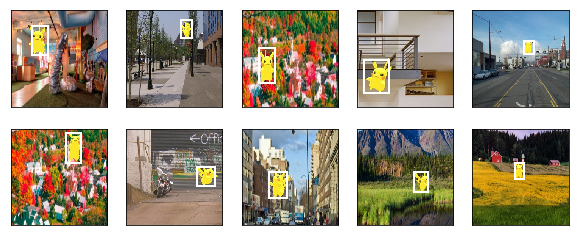

In [4]:
imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255
axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 小结

* 合成的皮卡丘数据集可用于测试目标检测模型。
* 目标检测的数据读取跟图像分类的类似。然而，在引入边界框后，标签形状和图像增广（如随机裁剪）发生了变化。


## 练习

* 查阅MXNet文档，`image.ImageDetIter`和`image.CreateDetAugmenter`这两个类的构造函数有哪些参数？它们的意义是什么？




## 参考文献

[1] im2rec工具。https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py

[2] GluonCV 工具包。https://gluon-cv.mxnet.io/

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/7022)

![](../img/qr_object-detection-dataset.svg)